In [54]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

from transformers import *

import collections
import os

import nltk
%matplotlib inline

from pandas import Series,DataFrame
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# 处理 DiffVec的数据
filename = 'diffvec_word_pairs_final.SEMBLESS.csv'
file_colname=['relation','word1','word2']
df = pd.read_csv(filename,header=None,names=file_colname)

df

,relation,word1,word2
0,ATTRIBUTE$Action:ObjectAttribute,apple,picker
1,ATTRIBUTE$Action:ObjectAttribute,collect,fee
2,ATTRIBUTE$Action:ObjectAttribute,hunter,game
3,ATTRIBUTE$Action:ObjectAttribute,paint,house
4,ATTRIBUTE$Action:ObjectAttribute,vitamin,deficiency
...,...,...,...
12453,vn-deriv,yawn,yawning
12454,vn-deriv,yearn,yearning
12455,vn-deriv,yell,yelling
12456,vn-deriv,yield,yielding


In [56]:
df = df[df['relation'].str.contains('CAUSE')]
df

,relation,word1,word2
71,CAUSE-PURPOSE$Action/Activity:Goal,advertise,promote
72,CAUSE-PURPOSE$Action/Activity:Goal,assault,injure
73,CAUSE-PURPOSE$Action/Activity:Goal,bathe,clean
74,CAUSE-PURPOSE$Action/Activity:Goal,breathe,live
75,CAUSE-PURPOSE$Action/Activity:Goal,burnish,shine
...,...,...,...
315,CAUSE-PURPOSE$Prevention,sleep,tiredness
316,CAUSE-PURPOSE$Prevention,sun,darkness
317,CAUSE-PURPOSE$Prevention,swimming,drowning
318,CAUSE-PURPOSE$Prevention,vaccine,virus


In [57]:
df['relation'].value_counts()

CAUSE-PURPOSE$Cause:Effect                 38
CAUSE-PURPOSE$Action/Activity:Goal         36
CAUSE-PURPOSE$EnablingAgent:Object         34
CAUSE-PURPOSE$Prevention                   33
CAUSE-PURPOSE$Agent:Goal                   31
CAUSE-PURPOSE$Instrument:Goal              29
CAUSE-PURPOSE$Cause:CompensatoryAction     28
CAUSE-PURPOSE$Instrument:IntendedAction    20
Name: relation, dtype: int64

In [5]:
# 为每一种 CAUSE 创建一个句式

In [58]:
# 为各个类型创建字典
effect = {}
action_goal = {}
enablingAgent_object = {}
prevention = {}
agent_goal = {}
instrument_goal = {}
compensatory_action = {}
instrument = {}


cause_class = {
    'CAUSE-PURPOSE$Cause:Effect':effect,
    'CAUSE-PURPOSE$Action/Activity:Goal':action_goal,
    'CAUSE-PURPOSE$EnablingAgent:Object':enablingAgent_object,
    'CAUSE-PURPOSE$Prevention':prevention,
    'CAUSE-PURPOSE$Agent:Goal':agent_goal,
    'CAUSE-PURPOSE$Instrument:Goal':instrument_goal,
    'CAUSE-PURPOSE$Cause:CompensatoryAction':compensatory_action,
    'CAUSE-PURPOSE$Instrument:IntendedAction':instrument
}

In [59]:

for index, row in df.iterrows():
    # 先判断是否是已经存在的 key
    if (row['word1'] in cause_class[row['relation']].keys()):
        cause_class[row['relation']][row['word1']].append(row['word2'])
    else:
        cause_class[row['relation']][row['word1']] = [row['word2']]
    
    
print(effect)
print(len(effect))

{'accident': ['damage'], 'bath': ['cleanliness'], 'cold': ['sneeze'], 'digging': ['hole'], 'disagreement': ['anger'], 'disease': ['sickness'], 'eating': ['fullness'], 'education': ['expertise'], 'exercise': ['fatigue', 'fitness'], 'experience': ['confidence'], 'explosion': ['damage'], 'fire': ['burns'], 'food': ['fullness'], 'germs': ['sickness'], 'headache': ['stress'], 'heater': ['warmth'], 'hit': ['injury'], 'illness': ['discomfort'], 'injury': ['pain'], 'learning': ['study'], 'loss': ['grief'], 'question': ['answer'], 'repetition': ['boredom'], 'run': ['sweat'], 'sadness': ['tears'], 'sex': ['pregnancy'], 'showering': ['cleanliness'], 'sow': ['germinate'], 'stimulus': ['response'], 'stress': ['headache'], 'study': ['learning'], 'sugar': ['energy'], 'sweating': ['odor'], 'tiredness': ['sleep'], 'tragedy': ['tears'], 'workout': ['sweat'], 'yelling': ['anger']}
37


In [60]:
templates = {
    'CAUSE-PURPOSE$Cause:Effect':'* causes _ .',
    'CAUSE-PURPOSE$Action/Activity:Goal':'* leads to _ .',
    'CAUSE-PURPOSE$EnablingAgent:Object':'Without * , _ can not work .',
    'CAUSE-PURPOSE$Prevention':'* can prevent _ .',
    'CAUSE-PURPOSE$Agent:Goal':'The goal of * is _ .',
    'CAUSE-PURPOSE$Instrument:Goal':'The goal of * is to provide _ .',
    'CAUSE-PURPOSE$Cause:CompensatoryAction':'* can be relieved by _ .',
    'CAUSE-PURPOSE$Instrument:IntendedAction':'A * is used to _ .'
}

In [61]:
models = {}

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model, tokenizer, mask_token = models['roberta-large']

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------------
accident['damage']
accident causes _ .
['death', 'injuries', 'a', 'coma', 'injury', 'paralysis', 'the', '', 'fatal', '.']
tensor([0.0952, 0.0601, 0.0400, 0.0379, 0.0369, 0.0264, 0.0235, 0.0163, 0.0145,
        0.0143])
['damage']
----------------
damage
----------------
{'damage': tensor(0.0061)}
max_probe is: tensor(0.0061)
20
40
the position of max probe is: 25
-----------------------------------------------------
*****************************************************
---------------
bath['cleanliness']
bath causes _ .
['.', 'and', 'the', '', 'a', 'to', '', 'headaches', 'you', 'it']
tensor([0.0786, 0.0477, 0.0399, 0.0357, 0.0295, 0.0245, 0.0184, 0.0153, 0.0140,
        0.0131])
['cleanliness']
----------------
cleanliness
----------------
cleanlinessis not in list
{}
---------------
cold['sneeze']
cold causes _ .
['', 'headaches', 'pneumonia', '.', '', 'death', 'arthritis', 'cancer', 'the', 'and']
tensor([0.0419, 0.0308, 0.0307, 0.0284, 0.0257, 0.0230, 0.0218, 0.0206, 

['of', 'and', 'the', '.', 'to', 'a', 'for', '', 'an', ',']
tensor([0.0754, 0.0728, 0.0671, 0.0596, 0.0595, 0.0582, 0.0216, 0.0200, 0.0187,
        0.0123])
['injury']
----------------
injury
----------------
{'injury': tensor(0.0027)}
max_probe is: tensor(0.0027)
20
40
the position of max probe is: 34
-----------------------------------------------------
*****************************************************
---------------
illness['discomfort']
illness causes _ .
['death', 'pain', 'illness', 'depression', 'disease', 'stress', 'suicide', 'mortality', 'suffering', 'sickness']
tensor([0.2671, 0.0520, 0.0313, 0.0290, 0.0226, 0.0193, 0.0162, 0.0147, 0.0146,
        0.0136])
['discomfort']
----------------
discomfort
----------------
{'discomfort': tensor(0.0012)}
max_probe is: tensor(0.0012)
20
40
80
160
the position of max probe is: 104
-----------------------------------------------------
*****************************************************
---------------
injury['pain']
injury causes _ 

['.', 'and', 'the', 'inflammation', 'a', 'headaches', 'fatigue', 'burning', ',', 'fever']
tensor([0.0496, 0.0444, 0.0434, 0.0371, 0.0292, 0.0279, 0.0190, 0.0158, 0.0134,
        0.0133])
['odor']
----------------
odor
----------------
{'odor': tensor(0.0004)}
max_probe is: tensor(0.0004)
20
40
80
160
320
the position of max probe is: 247
-----------------------------------------------------
*****************************************************
---------------
tiredness['sleep']
tiredness causes _ .
['insomnia', 'headaches', 'depression', 'fatigue', 'stress', 'anxiety', 'pain', 'nausea', '.', 'exhaustion']
tensor([0.1108, 0.1040, 0.0697, 0.0536, 0.0362, 0.0290, 0.0193, 0.0178, 0.0161,
        0.0117])
['sleep']
----------------
sleep
----------------
{'sleep': tensor(0.0060)}
max_probe is: tensor(0.0060)
20
40
the position of max probe is: 27
-----------------------------------------------------
*****************************************************
---------------
tragedy['tears']
trage

['arrest', 'shooting', 'death', '..', 'stabbing', 'shootout', '.', 'arrests', '...', 'murder']
tensor([0.0805, 0.0797, 0.0731, 0.0504, 0.0339, 0.0237, 0.0228, 0.0200, 0.0175,
        0.0171])
['defend', 'win']
----------------
defend
----------------
----------------
win
----------------
{'defend': tensor(1.5009e-06), 'win': tensor(0.0004)}
max_probe is: tensor(0.0004)
20
40
80
160
320
the position of max probe is: 204
-----------------------------------------------------
*****************************************************
---------------
flirt['seduce']
flirt leads to _ .
['sex', 'romance', 'love', 'attraction', 'success', 'passion', 'marriage', 'lust', 'commitment', '..']
tensor([0.0605, 0.0345, 0.0339, 0.0297, 0.0282, 0.0235, 0.0230, 0.0160, 0.0139,
        0.0138])
['seduce']
----------------
seduce
----------------
seduceis not in list
{}
---------------
ignite['burn']
ignite leads to _ .
['the', 'a', '.', '', '...', 'an', 'more', 'this', ':', 'fire']
tensor([0.0879, 0.0485, 0.0

['orgasm', 'a', 'rape', 'sex', 'the', '.', 'an', 'âĢ¦', '..', 'masturbation']
tensor([0.1614, 0.0785, 0.0418, 0.0387, 0.0168, 0.0137, 0.0121, 0.0107, 0.0102,
        0.0093])
['punish']
----------------
punish
----------------
{'punish': tensor(4.4847e-05)}
max_probe is: tensor(4.4847e-05)
20
40
80
160
320
640
1280
2560
the position of max probe is: 1785
-----------------------------------------------------
*****************************************************
---------------
speak['communicate', 'express']
speak leads to _ .
['the', '.', 'a', '/s>', 'action', 'silence', 'and', 'talk', 'truth', 'more']
tensor([0.0693, 0.0314, 0.0311, 0.0133, 0.0126, 0.0102, 0.0098, 0.0086, 0.0085,
        0.0082])
['communicate', 'express']
----------------
communicate
----------------
----------------
express
----------------
{'communicate': tensor(0.0002), 'express': tensor(0.0001)}
max_probe is: tensor(0.0002)
20
40
80
160
320
640
1280
the position of max probe is: 952
------------------------------

['we', 'you', 'I', 'film', 'video', 'camera', 'it', 'i', 'movie', 'computer']
tensor([0.1042, 0.0936, 0.0497, 0.0476, 0.0454, 0.0394, 0.0383, 0.0230, 0.0197,
        0.0179])
['film']
----------------
film
----------------
{'film': tensor(0.0476)}
max_probe is: tensor(0.0476)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
---------------
chemical['firework']
Without chemical , _ can not work .
['it', 'you', 'we', 'machine', 'they', 'chemical', 'process', 'computer', 'chemistry', 'system']
tensor([0.0742, 0.0301, 0.0262, 0.0257, 0.0178, 0.0165, 0.0157, 0.0123, 0.0119,
        0.0114])
['firework']
----------------
firework
----------------
fireworkis not in list
{}
---------------
electricity['lamp', 'stove', 'television', 'tv']
Without electricity , _ can not work .
['you', 'we', 'computers', 'I', 'it', 'people', 'We', 'electronics', 'You', 'water']
tensor([0.1956, 0.1388, 0.0693, 0.0283, 0.022

['you', 'we', 'it', 'water', 'engines', 'oil', 'plants', 'they', 'We', 'electricity']
tensor([0.0799, 0.0717, 0.0590, 0.0546, 0.0288, 0.0269, 0.0235, 0.0155, 0.0144,
        0.0144])
['lamp']
----------------
lamp
----------------
{'lamp': tensor(0.0004)}
max_probe is: tensor(0.0004)
20
40
80
160
320
the position of max probe is: 257
-----------------------------------------------------
*****************************************************
---------------
remote['television', 'tv']
Without remote , _ can not work .
['remote', 'you', 'it', 'we', 'I', 'this', 'server', 'command', 'they', 'i']
tensor([0.0934, 0.0885, 0.0734, 0.0694, 0.0211, 0.0174, 0.0164, 0.0146, 0.0143,
        0.0129])
['television', 'tv']
----------------
television
----------------
----------------
tv
----------------
{'television': tensor(8.2897e-05), 'tv': tensor(0.0002)}
max_probe is: tensor(0.0002)
20
40
80
160
320
640
the position of max probe is: 506
-----------------------------------------------------
*******

['the', 'infection', 'cancer', 'infections', 'this', 'a', 'obesity', '', '.', 'and']
tensor([0.0280, 0.0249, 0.0239, 0.0201, 0.0193, 0.0193, 0.0192, 0.0160, 0.0156,
        0.0147])
['slow']
----------------
slow
----------------
{'slow': tensor(0.0001)}
max_probe is: tensor(0.0001)
20
40
80
160
320
640
1280
the position of max probe is: 1011
-----------------------------------------------------
*****************************************************
---------------
food['hunger']
food can prevent _ .
['obesity', 'cancer', 'pregnancy', 'infection', 'diabetes', 'infections', 'depression', 'the', 'seizures', 'disease']
tensor([0.0629, 0.0609, 0.0572, 0.0363, 0.0363, 0.0242, 0.0240, 0.0163, 0.0160,
        0.0150])
['hunger']
----------------
hunger
----------------
{'hunger': tensor(0.0058)}
max_probe is: tensor(0.0058)
20
40
the position of max probe is: 28
-----------------------------------------------------
*****************************************************
---------------
fungicide

['depression', 'obesity', 'insomnia', 'stress', 'infection', 'fatigue', 'infections', 'pregnancy', 'diabetes', 'cancer']
tensor([0.0866, 0.0473, 0.0400, 0.0349, 0.0347, 0.0337, 0.0293, 0.0256, 0.0246,
        0.0240])
['exhaustion']
----------------
exhaustion
----------------
{'exhaustion': tensor(0.0030)}
max_probe is: tensor(0.0030)
20
40
80
the position of max probe is: 45
-----------------------------------------------------
*****************************************************
---------------
shot['disease']
shot can prevent _ .
['a', 'cancer', 'the', 'pregnancy', 'injury', 'seizures', 'paralysis', 'infection', '.', 'this']
tensor([0.0567, 0.0409, 0.0389, 0.0344, 0.0199, 0.0197, 0.0190, 0.0172, 0.0153,
        0.0138])
['disease']
----------------
disease
----------------
{'disease': tensor(0.0043)}
max_probe is: tensor(0.0043)
20
40
the position of max probe is: 31
-----------------------------------------------------
*****************************************************
-------

['to', '', ':', '.', 'the', 'success', ',', 'performance', 'that', '...']
tensor([0.2408, 0.0980, 0.0930, 0.0463, 0.0161, 0.0139, 0.0136, 0.0115, 0.0095,
        0.0094])
['applause']
----------------
applause
----------------
{'applause': tensor(0.0008)}
max_probe is: tensor(0.0008)
20
40
80
160
the position of max probe is: 99
-----------------------------------------------------
*****************************************************
---------------
doctor['wellness']
The goal of doctor is _ .
['to', '', ':', '.', 'health', 'education', 'cure', 'success', 'happiness', 'medicine']
tensor([0.0840, 0.0709, 0.0641, 0.0420, 0.0273, 0.0208, 0.0175, 0.0161, 0.0155,
        0.0110])
['wellness']
----------------
wellness
----------------
{'wellness': tensor(0.0003)}
max_probe is: tensor(0.0003)
20
40
80
160
320
640
the position of max probe is: 330
-----------------------------------------------------
*****************************************************
---------------
farmer['food', 'harves

['to', ':', 'success', '', '.', 'fame', 'singing', 'recognition', '...', 'performance']
tensor([0.1073, 0.0800, 0.0691, 0.0600, 0.0247, 0.0224, 0.0124, 0.0123, 0.0112,
        0.0104])
['contract']
----------------
contract
----------------
{'contract': tensor(4.1909e-05)}
max_probe is: tensor(4.1909e-05)
20
40
80
160
320
640
1280
2560
the position of max probe is: 1586
-----------------------------------------------------
*****************************************************
---------------
student['degree', 'graduation']
The goal of student is _ .
['to', '', ':', 'education', '.', 'success', 'the', ',', 'learning', 'that']
tensor([0.2091, 0.1289, 0.0818, 0.0698, 0.0456, 0.0298, 0.0142, 0.0134, 0.0093,
        0.0081])
['degree', 'graduation']
----------------
degree
----------------
----------------
graduation
----------------
{'degree': tensor(0.0003), 'graduation': tensor(0.0074)}
max_probe is: tensor(0.0074)
20
the position of max probe is: 10
-------------------------------------

['comfort', 'pleasure', 'love', 'affection', 'entertainment', 'happiness', 'food', 'shelter', 'warmth', 'protection']
tensor([0.1845, 0.0654, 0.0600, 0.0427, 0.0404, 0.0399, 0.0369, 0.0341, 0.0248,
        0.0209])
['companionship']
----------------
companionship
----------------
companionshipis not in list
{}
---------------
education['enlightenment']
The goal of education is to provide _ .
['knowledge', 'information', 'education', 'opportunity', '.', 'learning', 'opportunities', 'understanding', 'skills', 'literacy']
tensor([0.6105, 0.0607, 0.0246, 0.0204, 0.0189, 0.0170, 0.0153, 0.0149, 0.0143,
        0.0100])
['enlightenment']
----------------
enlightenment
----------------
{'enlightenment': tensor(0.0052)}
max_probe is: tensor(0.0052)
20
the position of max probe is: 15
-----------------------------------------------------
*****************************************************
---------------
fidelity['devotion']
The goal of fidelity is to provide _ .
['truth', 'consistency', '.',

['shock', 'information', 'entertainment', 'excitement', 'fear', 'provocation', 'pain', 'answers', 'attention', 'outrage']
tensor([0.0582, 0.0510, 0.0294, 0.0278, 0.0268, 0.0227, 0.0166, 0.0141, 0.0130,
        0.0120])
['insult']
----------------
insult
----------------
{'insult': tensor(0.0003)}
max_probe is: tensor(0.0003)
20
40
80
160
320
640
the position of max probe is: 347
-----------------------------------------------------
*****************************************************
---------------
punch['pain']
The goal of punch is to provide _ .
['pain', 'shock', 'force', 'a', 'feedback', 'surprise', 'energy', 'power', 'momentum', 'punch']
tensor([0.0585, 0.0538, 0.0537, 0.0419, 0.0237, 0.0226, 0.0225, 0.0224, 0.0208,
        0.0175])
['pain']
----------------
pain
----------------
{'pain': tensor(0.0585)}
max_probe is: tensor(0.0585)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
---------

['taking', 'using', 'sleeping', 'the', 'and', 'eating', 'a', 'drinking', 'exercising', 'exercise']
tensor([0.0594, 0.0502, 0.0488, 0.0444, 0.0439, 0.0423, 0.0341, 0.0315, 0.0256,
        0.0244])
['drunk']
----------------
drunk
----------------
{'drunk': tensor(7.5244e-05)}
max_probe is: tensor(7.5244e-05)
20
40
80
160
320
640
1280
the position of max probe is: 704
-----------------------------------------------------
*****************************************************
---------------
embarrassed['blush']
embarrassed can be relieved by _ .
['eating', '.', 'the', 'exercising', 'or', 'using', 'and', 'a', 'laughing', 'crying']
tensor([0.0734, 0.0442, 0.0397, 0.0383, 0.0361, 0.0340, 0.0329, 0.0311, 0.0207,
        0.0195])
['blush']
----------------
blush
----------------
{'blush': tensor(1.6593e-05)}
max_probe is: tensor(1.6593e-05)
20
40
80
160
320
640
1280
2560
the position of max probe is: 2233
-----------------------------------------------------
***********************************

['meditation', 'eating', '.', 'exercising', 'exercise', 'sleeping', 'crying', 'laughing', '', 'sleep']
tensor([0.1322, 0.0620, 0.0382, 0.0311, 0.0304, 0.0300, 0.0295, 0.0239, 0.0229,
        0.0194])
['cry']
----------------
cry
----------------
{'cry': tensor(4.4040e-05)}
max_probe is: tensor(4.4040e-05)
20
40
80
160
320
640
1280
the position of max probe is: 1042
-----------------------------------------------------
*****************************************************
---------------
sick['rest']
sick can be relieved by _ .
['eating', 'taking', 'using', 'drinking', 'and', 'exercising', 'the', 'sleeping', 'exercise', 'a']
tensor([0.0841, 0.0708, 0.0600, 0.0425, 0.0413, 0.0372, 0.0352, 0.0324, 0.0296,
        0.0284])
['rest']
----------------
rest
----------------
{'rest': tensor(0.0010)}
max_probe is: tensor(0.0010)
20
40
80
160
the position of max probe is: 99
-----------------------------------------------------
*****************************************************
---------------

['represent', 'buy', 'denote', 'measure', 'purchase', 'indicate', 'describe', 'store', 'pay', 'express']
tensor([0.2299, 0.2082, 0.1231, 0.1102, 0.0516, 0.0182, 0.0168, 0.0158, 0.0145,
        0.0106])
['purchase']
----------------
purchase
----------------
{'purchase': tensor(0.0516)}
max_probe is: tensor(0.0516)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
---------------
fork['eat']
A fork is used to _ .
['create', 'fork', 'generate', 'merge', 'split', 'modify', 'construct', 'extend', 'write', 'replace']
tensor([0.1406, 0.0442, 0.0265, 0.0185, 0.0169, 0.0142, 0.0137, 0.0119, 0.0115,
        0.0114])
['eat']
----------------
eat
----------------
{'eat': tensor(0.0004)}
max_probe is: tensor(0.0004)
20
40
80
160
320
the position of max probe is: 279
-----------------------------------------------------
*****************************************************
---------------
hammer['pound']
A ham

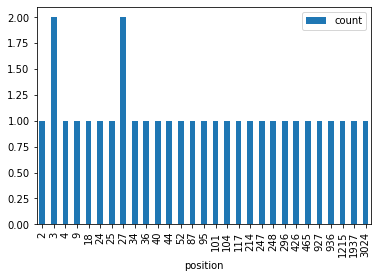

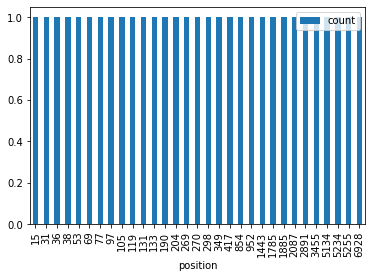

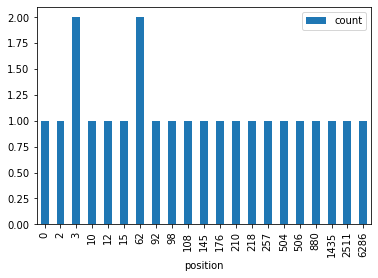

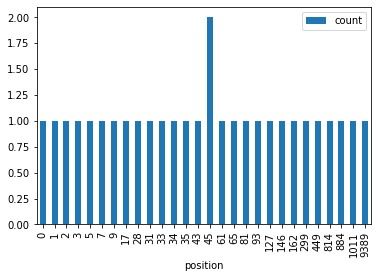

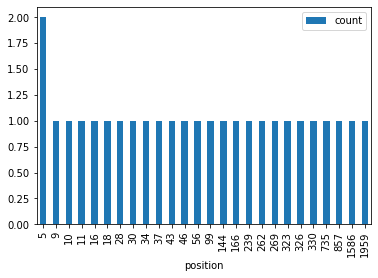

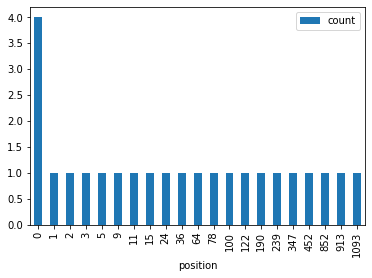

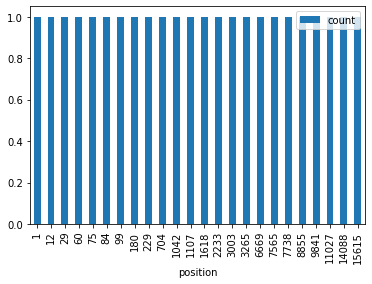

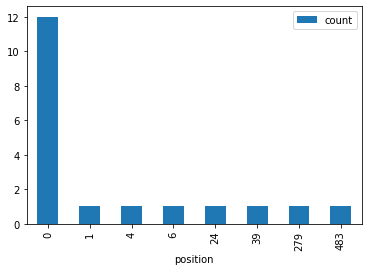

In [63]:
result_dict = {}

for key,value in cause_class.items():
    result_dict.update(value)


for (key,value) in templates.items():

    count_dict = {}
    data = cause_class[key]
    temp = value
    
    for (key,value) in data.items():
        
        print('---------------')
        print(key,end='')
        print(value)
    
    
        no_predict = 0
        print("==========================================================")
        text = temp.replace('*',key)
        print(text)

        # module
        if mask_token is not None:
            text = text.replace(' _ ', ' %s ' % mask_token)
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
        tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
        marker = '*'
        if marker in tokens:
            assert tokens.count(marker) == 2, str(tokens)
            p, h = [i for i, token in enumerate(tokens) if token == marker]
            tokens = [token for token in tokens if token != marker]
            h -= 1
            print(tokens[p], tokens[h])
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
        tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
                  for token in tokens] 
        #print(tokens)

        input_ids = torch.tensor([token_ids])
        with torch.no_grad():
            logits, attns = model(input_ids, output_attentions=True)
            probs = F.softmax(logits, dim=-1)

        for i in pred_idx:
            top_probs, top_indexes = probs[0][i].topk(10)
            top_tokens = tokenizer.convert_ids_to_tokens(top_indexes) 


            # remove G
            ans = []
            for word in top_tokens:
                ans.append(word[1:])
            print(ans)
            print(top_probs)


            # 找到每个同义词位于预测的第几个位置，先找到概率最大的，再去找最大的是预测的第几个
            # 找到每个同义词对应的概率
            word_probe = {}
            print(value)


            for word in value:
                print('----------------')
                print(word)
                print('----------------')

                word_id = tokenizer._convert_token_to_id('Ġ'+ word)
                if (word_id != 3):
                    word_probe[word] = probs[0][i][word_id]
                else:
                    print(word + 'is not in list')

                

            print(word_probe)
            
            # 没有反义词在预测的结果里
            # 保存计算结果的json文件中写为 -1
            if (len(word_probe)==0):
                no_predict = 1
                break
                
            

            # 找到同义词中概率最大的词和值
            max_word = max(word_probe, key=word_probe.get)
            max_probe = word_probe[max_word]

            print('max_probe is: ',end='')
            print(max_probe)

            # 判断概率最大的同义词是预测的第几个
            # 不要陷入死循环
            # k的值不要超过 tensor 的长度
            k = 10
            probe_get = 0
            while(probe_get == 0):
                top_probs, top_indexes = probs[0][i].topk(k)
                #print(top_probs)
                if max_probe in top_probs:
                    print('the position of max probe is: ',end='')
                    print((top_probs == max_probe).nonzero()[0].item())
                    print('-----------------------------------------------------')

                    probe_get = 1
                else:
                    k=k*2
                    print(k)
                    if (k >= list(probs[0][i].size())[0]):
                        top_probs, top_indexes = probs[0][i].topk(probs[0][i].size())
                        print(top_probs)
                        print('the position of max probe is: ',end='')
                        print((top_probs == max_probe).nonzero()[0].item())
                        print('-----------------------------------------------------')
                        probe_get = 1


            print('*****************************************************')


            
        # 没有预测结果
        if(no_predict == 1):
            # 写入结果文件
            result_dict[key] = [result_dict[key], -1]
            continue
            
            
        # 有预测结果
        position = (top_probs == max_probe).nonzero()[0].item()
        # 写入结果文件
        result_dict[key] = [result_dict[key], position]


        # 处理画图数据
        if position not in count_dict:
            count_dict[position] = 1
        else:
            count_dict[position]+=1
        
        
        
        
    # 画图
    count_dict_keys = count_dict.keys()
    count_dict_values = count_dict.values()

    data = {
        'count':Series(count_dict_values),
        'position':Series(count_dict_keys)
    }

    df = DataFrame(data)
    df.sort_values("position",inplace=True)
    print(df)
    # plt.bar(count_dict_keys,count_dict_values)
    df.plot(x='position',y='count',kind='bar')



# 保存到json文件
with open("result_cause.json", "w") as outfile:  
    json.dump(result_dict, outfile)